In [325]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style="darkgrid")
import os
import sys
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import spatial
from scipy.signal import savgol_filter,argrelextrema
from scipy.optimize import curve_fit, differential_evolution
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

## Variables

In [249]:
lightname = "light"
lightunit = "ppfd"
timename = "time[s]"
hourname = "time[h]"
doublename = "doubling time[h]"
maxname = "max growth rate [doublings/hr]"
odtype = "680" # which OD to use
odname = "OD("+odtype+"nm)"
filetype = '.csv'
lightcons = 8 #number of different light conditions used
repnum = 3 #number of replicates

cols = [timename,250,500,750,1000,1250,1500,1750,2000,"replicate"]
colnames = []
for i in range(len(cols)):
    if i == 0 or i==len(cols)-1:
        colnames.append(cols[i])
        continue
    col = odname+str(cols[i])
    colnames.append(col)
print(colnames)

['time[s]', 'OD(680nm)250', 'OD(680nm)500', 'OD(680nm)750', 'OD(680nm)1000', 'OD(680nm)1250', 'OD(680nm)1500', 'OD(680nm)1750', 'OD(680nm)2000', 'replicate']


## Functions

In [ ]:
def smooth(y,x):
    yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3

## Cleaning Data

In [35]:
path = os.getcwd()
filenames = os.listdir() # run on all <filetype> files
# filenames = ['A4_A_09302020.csv','A4_B_10012020.csv','A4_C_10022020.csv'] #choose files to run on
replicates = [] #file that contains all replicates of an experiment
# light_dict = {} #format:: {250:[replicate1,rep2,rep3], 500:[replicate1,rep2,rep3]}
replicates_wide = [] #same as replicates but in wide format
runstart = [177,0,237] # row number where the experiment starts (found using excel)
i = 0
for name in (filenames):
    if filetype not in name:
        continue
    filepath = os.path.join(path,name)
    print("Processing:: "+name)
    
    #clean up csv
    A = pd.read_csv(name,skiprows=4,index_col=False)
    cols = [col for col in A.columns
            if odtype not in col and timename not in col]
#     print(cols) # column names to remove
    A = A.drop(columns=cols)
    A = A.drop(index = list(range(0,runstart[i]-1))) # trimming each replicate to the start of the run
#     print(A.head())
    repname = [i] * len(A)
    A["replicate"] = repname # numbering each replicate for later analysis
#     print(A.columns,'\n',colnames)
    A.columns = colnames
    
    #removing duplicate times in each
    len0 = len(A)
    A = A.drop_duplicates(subset=[timename])
    len1 = len(A)
    diff = len0 - len1
    if diff != 0:
        print(name+":: Dropped",diff,"rows with duplicate \""+timename+"\" values")
    
    # changing from seconds to hours and resetting experiment start time to 0
    s_to_h = 300 / 3600 # 300 seconds between readings / seconds in hour
    t_series = np.arange(0,len(A),1)*s_to_h
    A[timename] = t_series
    A = A.rename(columns={timename:hourname}) #change column name to hours
    
    #storing each replicate in wide format for later averaging and smoothing
    replicates_wide.append(A)
#     print(A)
    
    # changing data format to long for plotting
    A = pd.wide_to_long(A, odname, i=hourname, j=lightname)
    replicates.append(A)
    i+=1
    
replen = len(replicates)
df = pd.concat(replicates)
df.reset_index(inplace=True)

# adding ppfd because seaborn will ROUND if we just have an integer
df[lightname] = df[lightname].apply(lambda x: str(x) +" "+ lightunit)
df

Processing:: A4_A_09302020.csv
Processing:: A4_B_10012020.csv
Processing:: A4_C_10022020.csv


,time[h],light,replicate,OD(680nm)
0,0.000000,250 ppfd,0,0.104
1,0.083333,250 ppfd,0,0.107
2,0.166667,250 ppfd,0,0.108
3,0.250000,250 ppfd,0,0.110
4,0.333333,250 ppfd,0,0.114
...,...,...,...,...
6803,20.916667,2000 ppfd,2,2.775
6804,21.000000,2000 ppfd,2,2.775
6805,21.083333,2000 ppfd,2,2.696
6806,21.166667,2000 ppfd,2,2.775


## Curve Averaging and Smoothing

#### Averaging replicates

In [129]:
#shortening the curves to the minimum length curve
replength = 0 #minimum length curve
for rep in replicates_wide:
    length = len(rep)
    if replength == 0:
        replength = length
    elif replength > length:
        replength = length
reps = []
for rep in replicates_wide:
    short_rep = rep.iloc[:replength].reset_index(drop=True).drop(columns="replicate") #shorten and reset index
#     print(short_rep.tail())
    reps.append(short_rep)
    
# finding average and standard deviation at each time point and each light value
mean_od_df = pd.concat(reps).groupby(level=0).mean()
std_od_df = pd.concat(reps).groupby(level=0).std()
std_od_df[hourname] = mean_od_df[hourname]
mean_od_df

,time[h],OD(680nm)250,OD(680nm)500,OD(680nm)750,OD(680nm)1000,OD(680nm)1250,OD(680nm)1500,OD(680nm)1750,OD(680nm)2000
0,0.000000,0.109667,0.117000,0.120333,0.132000,0.129667,0.129000,0.108333,0.108000
1,0.083333,0.111333,0.120667,0.122000,0.134667,0.131000,0.129000,0.115000,0.108333
2,0.166667,0.113000,0.122000,0.123000,0.137667,0.133667,0.134000,0.116667,0.111333
3,0.250000,0.114000,0.122667,0.124667,0.141333,0.134333,0.133667,0.116000,0.112667
4,0.333333,0.114000,0.123000,0.127000,0.137667,0.134333,0.133000,0.117333,0.111333
...,...,...,...,...,...,...,...,...,...
218,18.166667,0.758333,1.829667,2.117667,2.141000,2.278333,2.254333,2.159000,2.114667
219,18.250000,0.762667,1.841667,2.117667,2.159667,2.284000,2.266333,2.159000,2.135333
220,18.333333,0.771000,1.847333,2.133000,2.179667,2.284000,2.278667,2.163333,2.136333
221,18.416667,0.777000,1.858000,2.138667,2.184667,2.277333,2.286667,2.186667,2.143333


#### Smoothing Curves

In [272]:
smooth = mean_od_df.copy(deep=True)
for (columnName, columnData) in smooth.iteritems():
    if columnName == hourname:
        continue
    smooth[columnName] = savgol_filter(columnData.values, 101, 2) # data array, window size, polynomial order
smooth

,time[h],OD(680nm)250,OD(680nm)500,OD(680nm)750,OD(680nm)1000,OD(680nm)1250,OD(680nm)1500,OD(680nm)1750,OD(680nm)2000
0,0.000000,0.112861,0.127150,0.137221,0.155037,0.153635,0.153697,0.136439,0.131279
1,0.083333,0.113408,0.127017,0.136257,0.153722,0.151983,0.151926,0.134637,0.129505
2,0.166667,0.113972,0.126949,0.135384,0.152509,0.150439,0.150264,0.132946,0.127839
3,0.250000,0.114553,0.126944,0.134603,0.151399,0.149003,0.148711,0.131364,0.126280
4,0.333333,0.115152,0.127004,0.133914,0.150392,0.147675,0.147266,0.129891,0.124829
...,...,...,...,...,...,...,...,...,...
218,18.166667,0.757737,1.841022,2.137816,2.148095,2.266285,2.248788,2.147670,2.100897
219,18.250000,0.763965,1.854933,2.147418,2.154404,2.271669,2.254141,2.151758,2.106408
220,18.333333,0.770227,1.868866,2.156914,2.160560,2.276861,2.259310,2.155658,2.111765
221,18.416667,0.776523,1.882819,2.166305,2.166562,2.281861,2.264295,2.159370,2.116971


#### Changing from wide to long format for plotting

In [87]:
smooth_wide = smooth.copy(deep=True)
smooth = pd.wide_to_long(smooth, odname, i=hourname, j=lightname)
smooth.reset_index(inplace=True)

# adding ppfd because seaborn will ROUND if we just have an integer
smooth[lightname] = smooth[lightname].apply(lambda x: str(x) +" "+ lightunit)
smooth

,time[h],light,OD(680nm)
0,0.000000,250 ppfd,0.112861
1,0.083333,250 ppfd,0.113408
2,0.166667,250 ppfd,0.113972
3,0.250000,250 ppfd,0.114553
4,0.333333,250 ppfd,0.115152
...,...,...,...
1779,18.166667,2000 ppfd,2.100897
1780,18.250000,2000 ppfd,2.106408
1781,18.333333,2000 ppfd,2.111765
1782,18.416667,2000 ppfd,2.116971


## Initial Plots

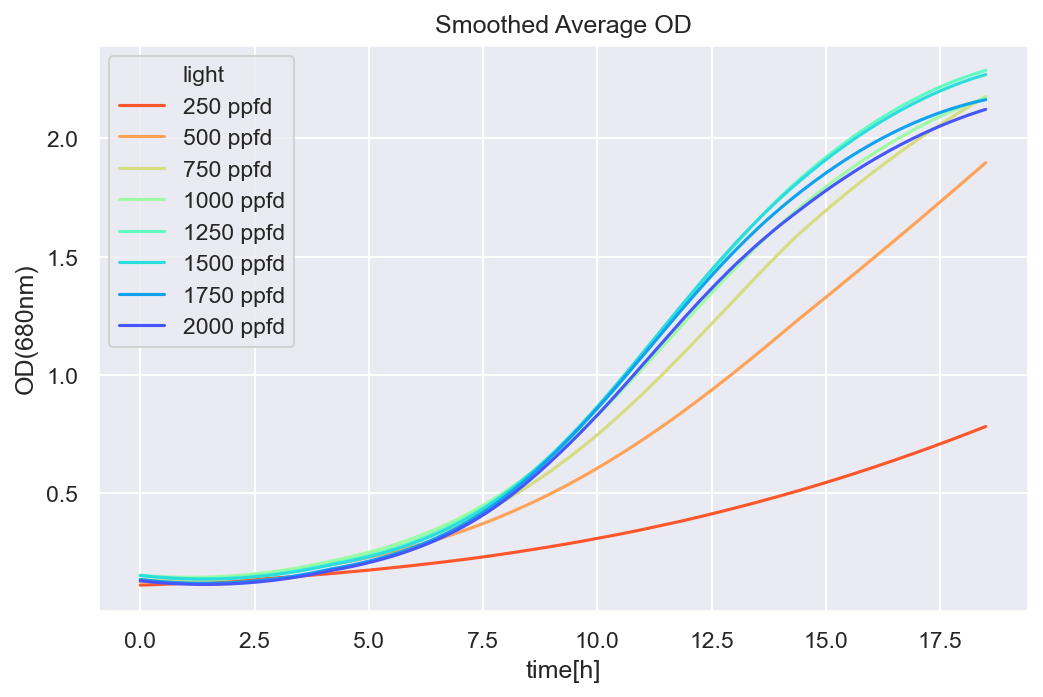

In [247]:
title = 'Smoothed Average OD'
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", lightcons)
g = sns.lineplot(x=hourname, y=odname,
             hue=lightname,
             palette=palette,data=smooth).set_title(title)

## Logistic Curve Fitting

In [322]:
def logistic_plot(xdata,ydata):

    
    def sigmoid(x, L ,x0, k, b):
        y = L / (1 + np.exp(-k*(x-x0)))+b
        return (y)

    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',maxfev=100000)
    ycompute = sigmoid(xdata,popt[0],popt[1],popt[2],popt[3])
    
    return ycompute

OD(680nm)250


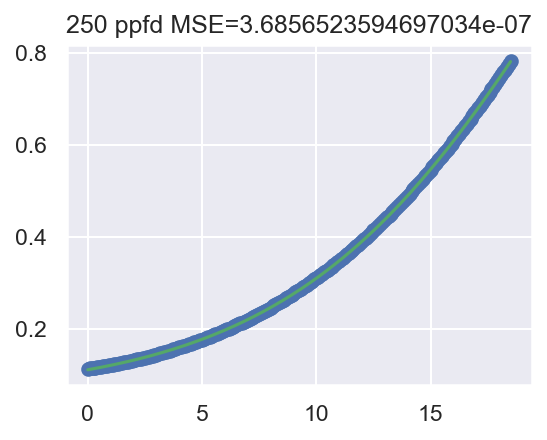

OD(680nm)500


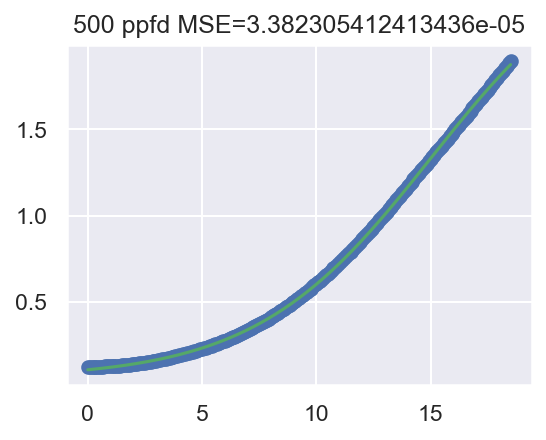

OD(680nm)750


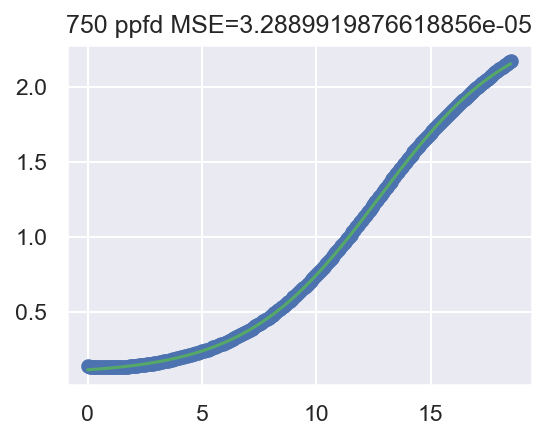

OD(680nm)1000


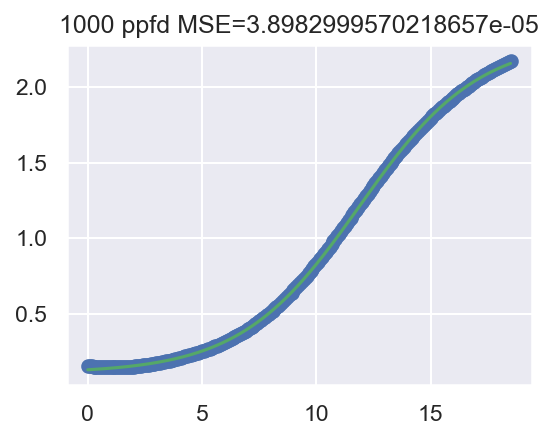

OD(680nm)1250


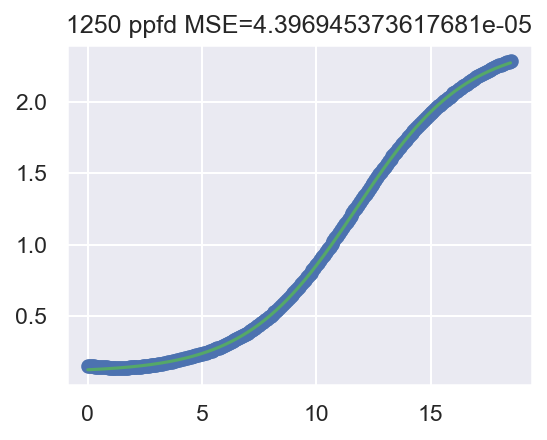

OD(680nm)1500


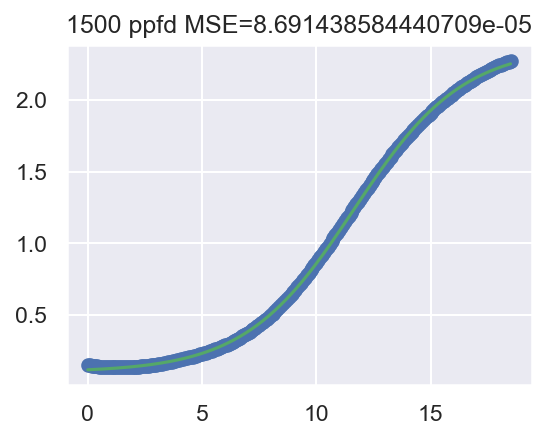

OD(680nm)1750


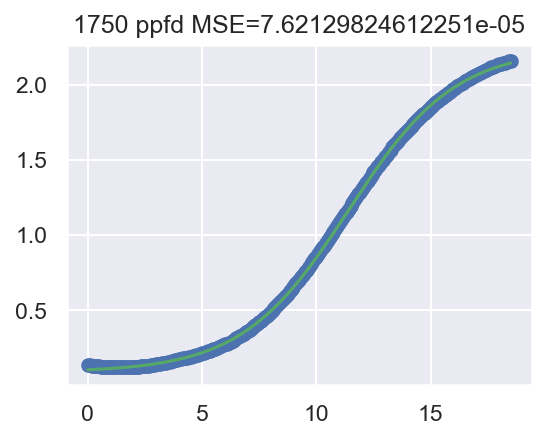

OD(680nm)2000


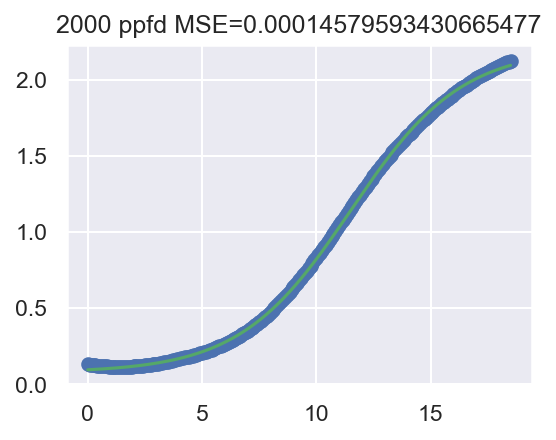

In [327]:
xdata = np.array(smooth[hourname])


for colname,ydata in smooth.iteritems():
    if colname == hourname:
        continue
    print(colname)
    ydata = np.array(ydata) 
    ycompute = logistic_plot(xdata,ydata)
    MSE = mse(ydata,ycompute)
    
    plt.figure(figsize=(4,3), dpi=150)
    plt.scatter(xdata,ydata)
    plt.plot(xdata,ycompute,color='g')
    plt.title(colname[len(odname):]+' ppfd '+'MSE='+str(MSE))
    plt.show()
    plt.close()

In [286]:
def logistic_plot(smooth):
    # from https://stackoverflow.com/questions/56329180/fitting-a-logistic-curve-to-data
    xData = np.array(smooth[hourname])

    def func(x, a, b, c, d):
        return a / (1.0 + np.exp(-c * (x - d))) + b

    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(xData, *parameterTuple)
        return np.sum((yData - val) ** 2.0)


    def generate_Initial_Parameters():
        parameterBounds = []
        parameterBounds.append([0.0, 100.0]) # search bounds for a
        parameterBounds.append([-10.0, 0.0]) # search bounds for b
        parameterBounds.append([0.0, 10.0]) # search bounds for c
        parameterBounds.append([0.0, 10.0]) # search bounds for d

        # "seed" the numpy random number generator for repeatable results
        result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    # by default, differential_evolution completes by calling curve_fit() using parameter bounds
    geneticParameters = generate_Initial_Parameters()

        


    ##########################################################
    # graphics output section
    def ModelAndScatterPlot(graphWidth, graphHeight):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
        axes = f.add_subplot(111)

        # first the raw data as a scatter plot
        for colname,yData in smooth.iteritems():
            
            # now call curve_fit without passing bounds from the genetic algorithm,
            # just in case the best fit parameters are outside those bounds
            fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
            print(colname)
            print('Fitted parameters:', fittedParameters)
            print()

            modelPredictions = func(xData, *fittedParameters) 

            absError = modelPredictions - yData

            SE = np.square(absError) # squared errors
            MSE = np.mean(SE) # mean squared errors
            RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
            Rsquared = 1.0 - (np.var(absError) / np.var(yData))

            print()
            print('RMSE:', RMSE)
            print('R-squared:', Rsquared)

            print()
            
#             axes.plot(xData, yData)
            # create data for the fitted equation plot
            xModel = np.linspace(min(xData), max(xData))
            yModel = func(xModel, *fittedParameters)

            # now the model as a line plot
            axes.plot(xModel, yModel)

        axes.set_xlabel(hourname) # X axis data label
        axes.set_ylabel(odname) # Y axis data label

        plt.show()
        plt.close('all') # clean up after using pyplot

    graphWidth = 800
    graphHeight = 600
    ModelAndScatterPlot(graphWidth, graphHeight)

time[h]
Fitted parameters: [ 9.0131154   0.23688463 -3.51339062 39.08964804]


RMSE: 5.364492313143692
R-squared: 1.1102230246251565e-16

OD(680nm)250
Fitted parameters: [ 1.96911218  0.0529529   0.16068249 21.81479478]


RMSE: 0.0006070957386993959
R-squared: 0.9999902498823138

OD(680nm)500
Fitted parameters: [ 2.55377627  0.0584816   0.2595472  15.02298054]


RMSE: 0.005815759118477602
R-squared: 0.9998876798273456

OD(680nm)750
Fitted parameters: [ 2.36068588  0.08509494  0.34229352 12.75525715]


RMSE: 0.005734973398074488
R-squared: 0.9999304139359252

OD(680nm)1000
Fitted parameters: [ 2.21054544  0.1074895   0.38380503 11.89269646]


RMSE: 0.006243636726317874
R-squared: 0.9999230259542065

OD(680nm)1250
Fitted parameters: [ 2.29771228  0.10857355  0.41395181 11.76456067]


RMSE: 0.006630946669690302
R-squared: 0.999925538425857

OD(680nm)1500
Fitted parameters: [ 2.2644044   0.10533078  0.41962563 11.64976742]


RMSE: 0.009322788522990653
R-squared: 0.9998516911129673

OD(680n

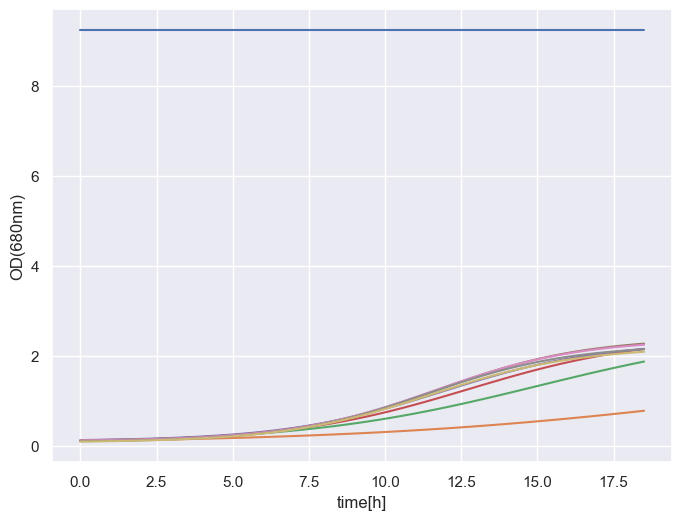

In [287]:
logistic_plot(smooth)

## Finding Max Growth Rate

In [103]:
#adapted minorly from https://github.com/Bahler-Lab/pyphe/blob/2de4c40bba4cb614e77cb4f503ec4f699144ef1e/pyphe/growthcurves.py#L50
def find_max_slope(x,t,fitrange, find_min_instead=False):
    '''Find max_slope, t_max, intercept and r2 for a single growthcurve. The regression is aware of the timepoints so this will work with unevenly samples growthcurves.
    Required arguments:
    x (array-like) -- 1D array-like containing the population/colony sizes
    t (array-like) -- 1D array-like containing the timepoints, must have same dimensions as x
    reg_fitrange (int) -- The number of timepoints over which to fit the linear regression
    Returns:
    {
    max_slope -- The slope of the regression
    t_max -- The mid-point of the fitrange of the regression
    intercept -- The y-inyercept of the regression
    r2 -- The R^2 value of the regression
    }
    '''
    regression_results = []

    for i in range(len(x)-fitrange):
        slope, intercept, r_value, p_value, std_err = stats.linregress(t[i:i+fitrange], x[i:i+fitrange])
        regression_results.append({'t_max':np.mean(t[i:i+fitrange]), 'max_slope':slope, 'r2':r_value**2, 'y-intercept':intercept})

    if find_min_instead:
        slope_result = pd.Series(min(regression_results, key=lambda x: x['max_slope']))
    else:
        slope_result = pd.Series(max(regression_results, key=lambda x: x['max_slope']))

    slope_result['x-intercept'] = -slope_result['y-intercept']/slope_result['max_slope']
    return slope_result

In [114]:
one_curve = smooth_wide["OD(680nm)750"].values
timepoints = smooth_wide[hourname].values
find_max_slope(one_curve,timepoints,5)

t_max          12.916667
max_slope       0.203801
r2              0.999999
y-intercept    -1.331617
x-intercept     6.533922
dtype: float64

In [336]:
repname = "replicate"
max_growth = {lightname:[], maxname:[],repname:[]}
timepoints = reps[0][hourname].values
lightvals = []
maxes = []
for colname,coldata in reps[0].iteritems():
    if colname == hourname:
        continue
    name = int(colname[len(odname):])
    for i,rep in enumerate(reps):
        column = rep[colname].values
        max_slope = find_max_slope(column,timepoints,5)["max_slope"]
        
        max_growth[lightname].append(name)
        max_growth[maxname].append(max_slope)
        max_growth[repname].append(i)
max_growth = pd.DataFrame(max_growth) #long format
max_growth_wide = max_growth.pivot_table(index=repname, #wide format
                                         columns=lightname,values=maxname)
max_growth[doublename] = max_growth[maxname].apply(lambda x: np.log(2)/x) # transform growth rate to doubling time

In [343]:
mean = max_growth.groupby(lightname).mean()[doublename]
std = max_growth.groupby(lightname).std()[doublename]
a = max_growth.copy(deep=True).groupby(lightname).mean()
a["Mean"] = mean
a["Standard Deviation"] = std
a = a.drop(columns=["replicate",maxname,doublename])
a

,Mean,Standard Deviation
light,,
250,6.376229,0.711108
500,3.463918,0.160972
750,2.735658,0.099089
1000,2.508654,0.259491
1250,2.446461,0.220631
1500,2.269282,0.348003
1750,2.157559,0.334936
2000,2.312219,0.328818


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1750 v.s. 2000: t-test independent samples, P_val=5.987e-01 stat=-5.707e-01
750 v.s. 1000: t-test independent samples, P_val=2.298e-01 stat=1.416e+00
500 v.s. 750: t-test independent samples, P_val=2.621e-03 stat=6.673e+00
250 v.s. 500: t-test independent samples, P_val=2.290e-03 stat=6.918e+00
750 v.s. 1750: t-test independent samples, P_val=4.562e-02 stat=2.867e+00


Text(52.87499999999999, 0.5, 'doubling time[h]')

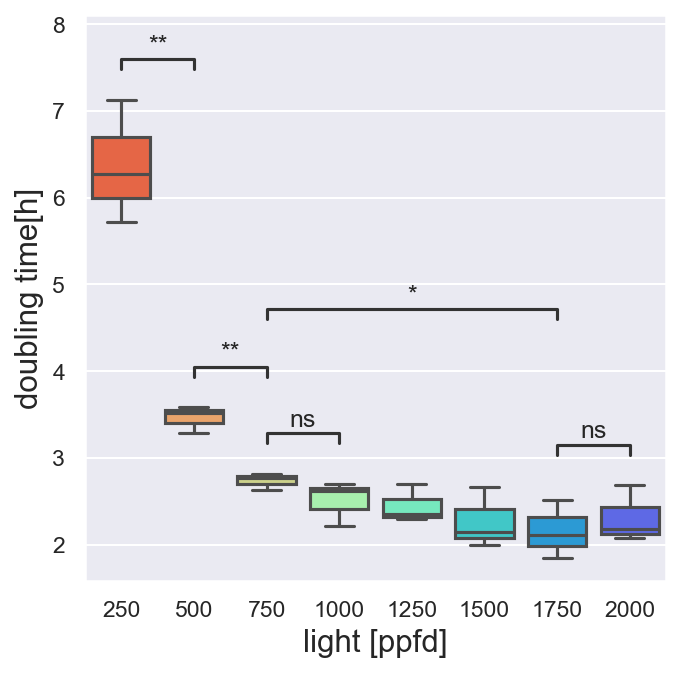

In [330]:
x = lightname
y = doublename
data = max_growth

plt.figure(figsize=(5,5), dpi=150)
palette = sns.color_palette("rainbow_r", lightcons)
ax = sns.boxplot(x=x, y=y,palette=palette,data=data)
add_stat_annotation(ax, data=data, x=x, y=y,
                    box_pairs=[(250, 500), (500,750), (750,1000),(750,1750),(1750,2000)][::-1],
                    test='t-test_ind', text_format='star', loc='inside', comparisons_correction=None, verbose=2)
ax.set_xlabel(x+' [ppfd]',fontsize=15)
ax.set_ylabel(y,fontsize=15)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

250 v.s. 500: t-test independent samples, P_val=5.098e-04 stat=-1.025e+01
500 v.s. 750: t-test independent samples, P_val=2.296e-03 stat=-6.914e+00
750 v.s. 1000: t-test independent samples, P_val=2.484e-01 stat=-1.350e+00
1750 v.s. 2000: t-test independent samples, P_val=5.713e-01 stat=6.159e-01
750 v.s. 1750: t-test independent samples, P_val=6.761e-02 stat=-2.488e+00


Text(20.999999999999993, 0.5, 'max growth rate [doublings/hr]')

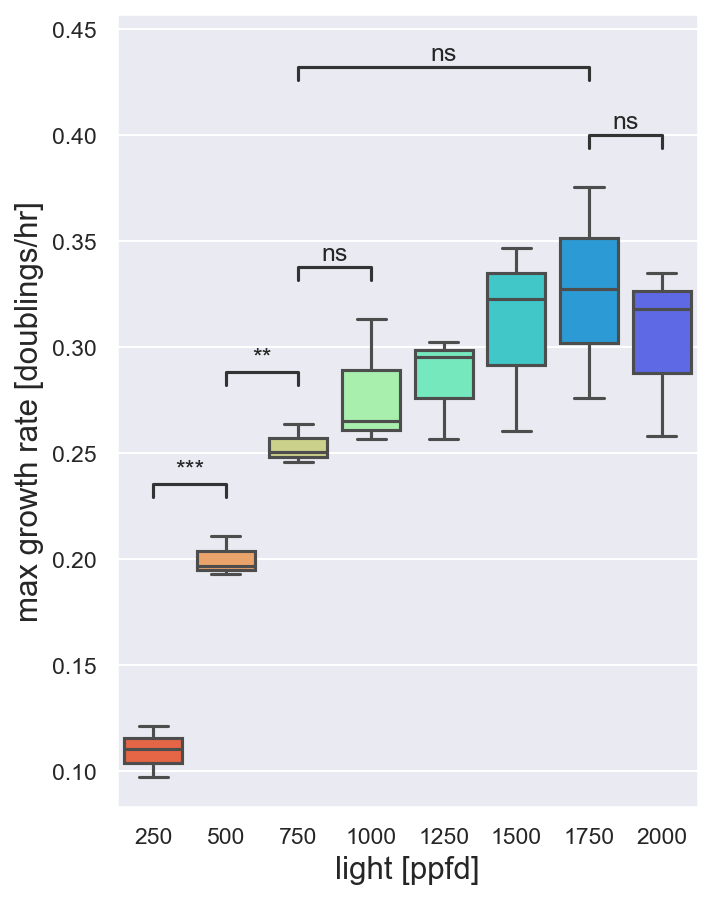

In [261]:
x = lightname
y = maxname
data = max_growth

plt.figure(figsize=(5,7), dpi=150)
palette = sns.color_palette("rainbow_r", lightcons)
ax = sns.boxplot(x=x, y=y,palette=palette,data=data)
add_stat_annotation(ax, data=data, x=x, y=y,
                    box_pairs=[(250, 500), (500,750), (750,1000),(750,1750),(1750,2000)],
                    test='t-test_ind', text_format='star', loc='inside', comparisons_correction=None, verbose=2)
ax.set_xlabel(x+' [ppfd]',fontsize=15)
ax.set_ylabel(y,fontsize=15)

## Plots without averaging

Text(0.5, 1.0, 'Holistic Replicate Comparison')

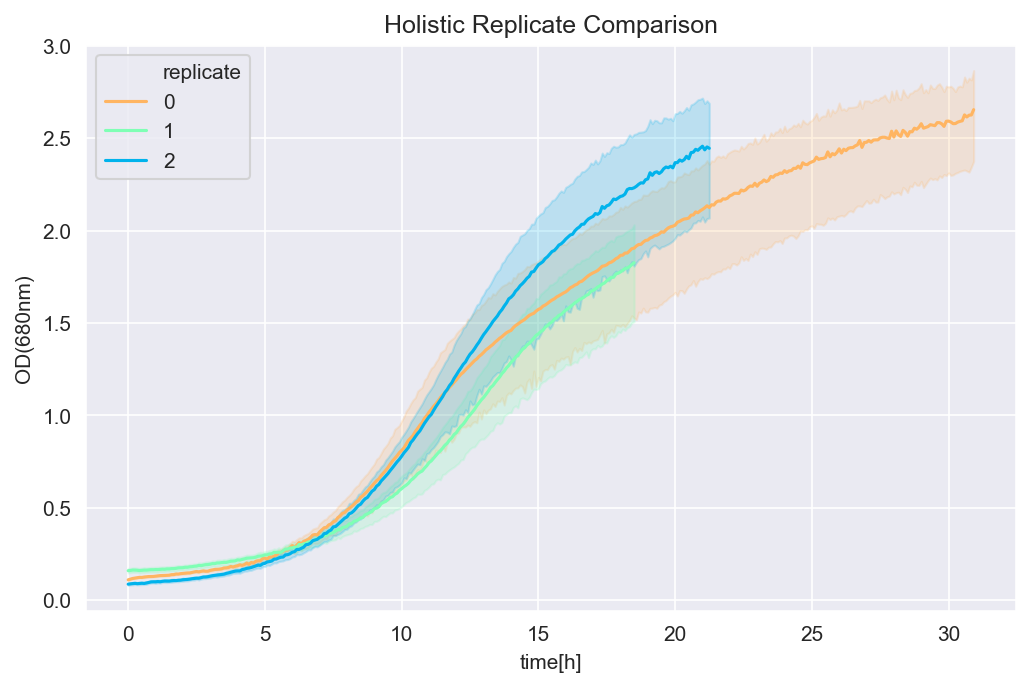

In [54]:
title = 'Holistic Replicate Comparison'
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", replen)
sns.lineplot(x=hourname, y=odname,hue="replicate",palette=palette,data=df).set_title(title)

In [50]:
# title = 'All Curves Plotted'
# plt.figure(figsize=(8,5), dpi=150)
# palette = sns.color_palette("rainbow_r", lightcons)
# g = sns.lineplot(x=hourname, y=odname,
#              hue=lightname, style="replicate",
#              palette=palette,data=df).set_title(title)

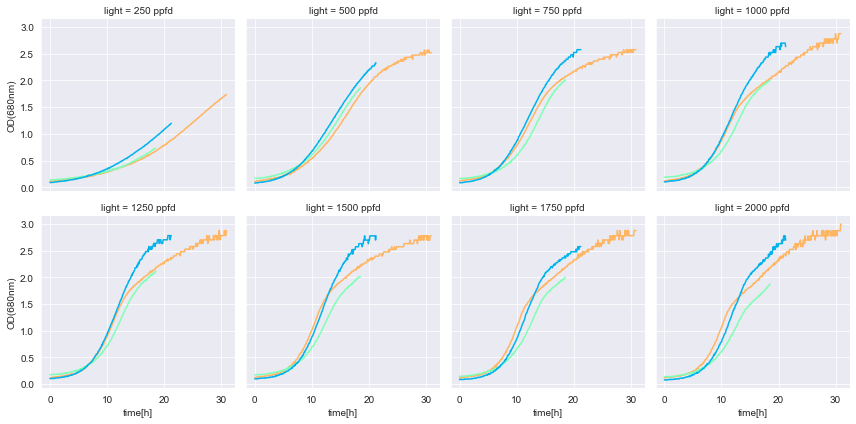

In [53]:
title = "Replicate Comparison"
# g = plt.figure(figsize=(12,8), dpi=300)
palette = sns.color_palette("rainbow_r", replen)
g = sns.FacetGrid(df, col=lightname, hue="replicate",col_wrap=4,palette=palette)
g.map(sns.lineplot, hourname, odname)

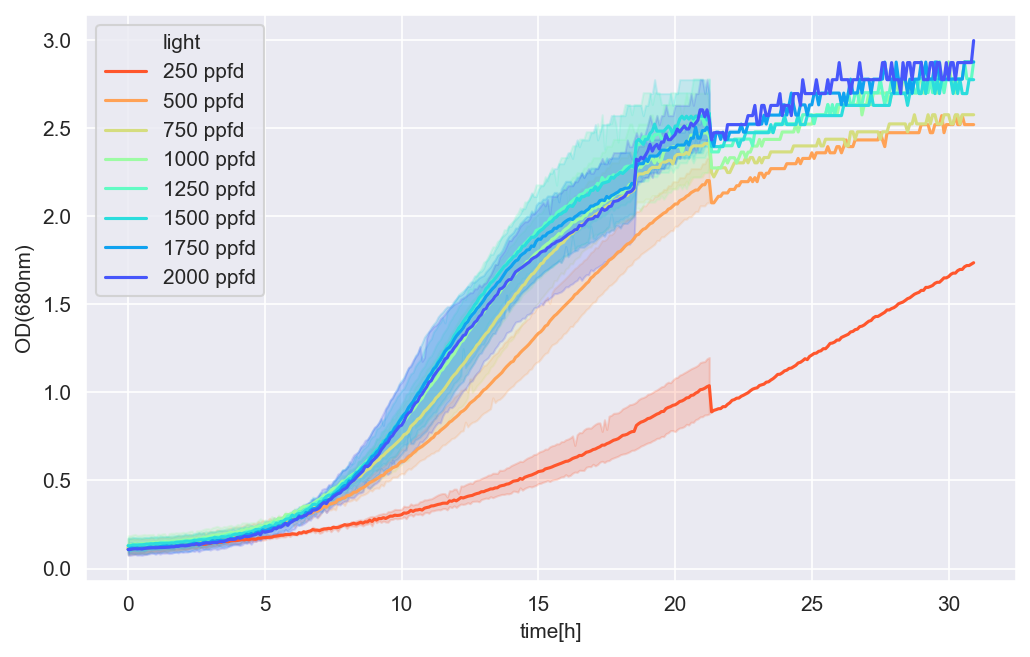

In [10]:
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", lightcons)
sns.lineplot(x=hourname, y=odname,hue=lightname,palette=palette,data=df)